# Dosimetría por absorbente único

In [107]:
import configparser
import pyfilmqa as fqa
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.measure import profile_line

In [2]:
config = configparser.ConfigParser()
config.read('filmQAp.config')

### DFS 1 m

In [32]:
im1ds = fqa.nlmf(imfile='Linealidad/DFS100_ds.tif', config=config)

In [6]:
im1D = fqa.nlmf(imfile='Linealidad/DFS100_D.tif', config=config)

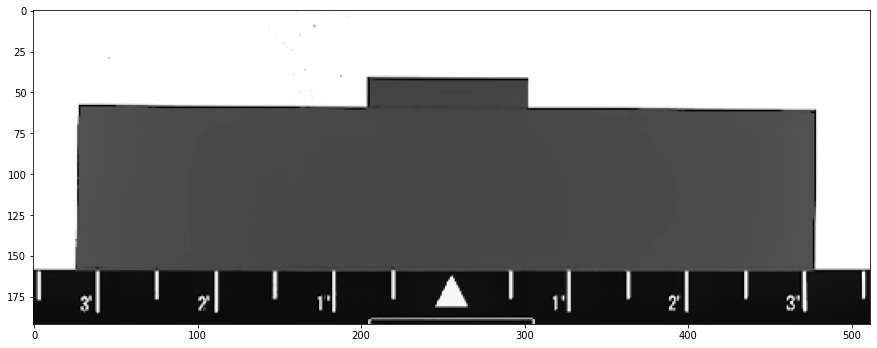

In [13]:
fig, ax = plt.subplots(figsize=(15, 45))
ax.imshow(im1ds[...,0], cmap=plt.cm.gray)
plt.show()

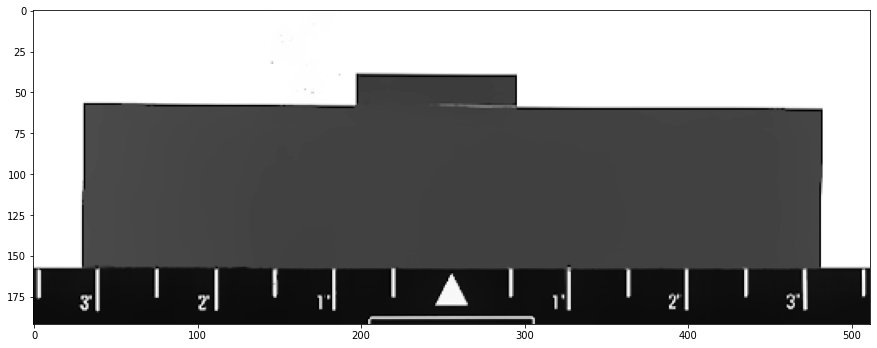

In [14]:
fig, ax = plt.subplots(figsize=(15, 45))
ax.imshow(im1D[...,0], cmap=plt.cm.gray)
plt.show()

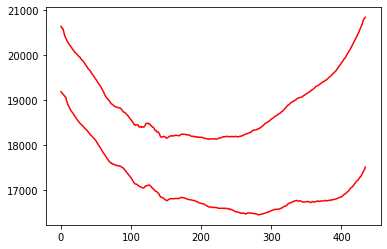

In [118]:
plt.plot(im1ds[100, 35:470, 0], 'r-')
plt.plot(im1D[100, 35:470, 0], 'r-')

In [36]:
im1dst = np.copy(im1ds)
im1dst[im1dst==0]=1
dim1ds = np.log10(65535/im1dst)

im1Dt = np.copy(im1D)
im1Dt[im1Dt==0]=1
dim1D = np.log10(65535/im1Dt)

im1d = np.log10(im1dst/im1Dt)

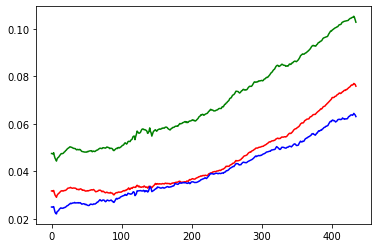

In [38]:
plt.plot(im1d[100, 35:470, 0], 'r-')
plt.plot(im1d[100, 35:470, 1], 'g-')
plt.plot(im1d[100, 35:470, 2], 'b-')

In [41]:
cdf = pd.read_excel('RacMPhMCalibs.xlsx', sheet_name='MultiFase')
cdf

,Unnamed: 0,f,phir,kr,phib,kb
0,R,0.152828,0.475975,0.060504,0.143839,0.399615
1,G,0.157737,0.782489,0.036325,0.093744,0.399615
2,B,0.237874,0.508790,0.036325,0.031596,0.399615


In [44]:
kra = cdf.kr
kra

0    0.060504
1    0.036325
2    0.036325
Name: kr, dtype: float64

In [70]:
im1d = np.log10(im1dst/im1Dt)
im1d[im1d <= 0] = 1e-6
cR, cG, cB = 1, 1, 1
DR = 1/kra[0] * np.log(cR/(cR+(im1d)))
DG = 1/kra[1] * np.log(cG/(cG+(im1d)))
DB = 1/kra[1] * np.log(cB/(cB+(im1d)))
D = DR
D[..., 1] = DG[..., 1]
D[..., 2] = DB[..., 2]

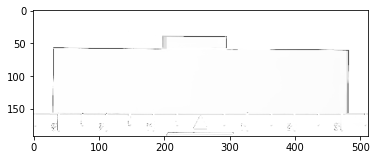

In [68]:
plt.imshow(D[...,0], cmap=plt.cm.gray)

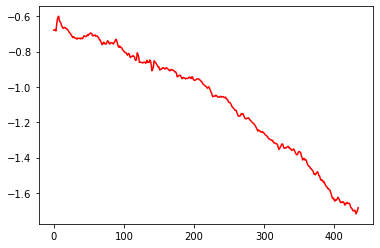

In [87]:
plt.plot(D[100, 35:470, 2], 'r-')

In [73]:
pddc = pd.read_excel('PDDCalib.xlsx')

In [139]:
pddc['Dr'] = pddc.D / pddc.D.max()
plandf = pddc.loc[(pddc.z > 1) & (pddc.z < 17)]

Resolución espacial

In [102]:
sr = 2.54/72
sr

0.035277777777777776

Pandas DataFrame con la posición y las densidades ópticas por canal

In [136]:
ddf = pd.DataFrame(profile_line(image=im1d, src=[100, 35], dst=[100, 470], linewidth=60), columns=['dR', 'dG', 'dB'])
film_size = 17
ddf['z'] = film_size - ddf.index * sr
ddf['dRr'] = ddf.dR / ddf.dR.max()
ddf['dGr'] = ddf.dG / ddf.dG.max()
ddf['dBr'] = ddf.dB / ddf.dB.max()
ddf

,dR,dG,dB,z,dRr,dGr,dBr
0,0.030882,0.046217,0.023514,17.000000,0.404313,0.440006,0.363954
1,0.030989,0.046412,0.023749,16.964722,0.405712,0.441862,0.367595
2,0.031031,0.046431,0.023858,16.929444,0.406266,0.442040,0.369273
3,0.031507,0.047137,0.024728,16.894167,0.412488,0.448764,0.382747
4,0.030923,0.046217,0.023746,16.858889,0.404846,0.440001,0.367542
...,...,...,...,...,...,...,...
431,0.076382,0.105038,0.064607,1.795278,1.000000,1.000000,1.000000
432,0.075816,0.104178,0.064059,1.760000,0.992590,0.991818,0.991515
433,0.075277,0.103243,0.063491,1.724722,0.985528,0.982911,0.982726
434,0.074570,0.102263,0.062867,1.689444,0.976276,0.973585,0.973061


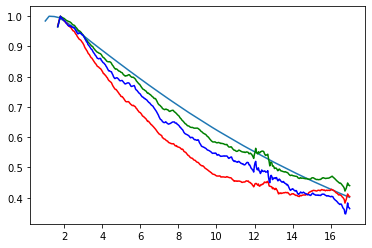

In [143]:
fig, ax = plt.subplots()
ax.plot(plandf.z, plandf.Dr)
ax.plot(ddf.z, ddf.dRr, 'r-')
ax.plot(ddf.z, ddf.dGr, 'g-')
ax.plot(ddf.z, ddf.dBr, 'b-')
plt.show()